In [39]:
# Importações

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
    PowerTransformer,
    QuantileTransformer,
    PolynomialFeatures,
)
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


import re


from src.config import CLEANED_PATH
from src.graphics import compareMetrics, plotCoeffs, plotResiduals, plotResidualsFromEstimator
from src.models import trainAndValidate, gridSearch
from src.utils import organizeResults, getCoeffsDataframe

In [40]:
# Obtendo os dados limpos
df = pd.read_parquet(CLEANED_PATH)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_households,population_per_households,bedrooms_per_rooms,median_income_cat,housing_median_age_cat
0,-122.25,37.849998,52,1274,235,558,219,5.6431,341300,NEAR BAY,5.817352,2.547945,0.184458,4,4
1,-122.25,37.849998,52,1627,280,565,259,3.8462,342200,NEAR BAY,6.281853,2.181467,0.172096,3,4
2,-122.25,37.849998,52,919,213,413,193,4.0368,269700,NEAR BAY,4.761658,2.139896,0.231774,3,4
3,-122.25,37.840000,52,2535,489,1094,514,3.6591,299200,NEAR BAY,4.931907,2.128405,0.192899,3,4
4,-122.25,37.840000,52,3104,687,1157,647,3.1200,241400,NEAR BAY,4.797527,1.788253,0.221327,3,4


In [41]:
# Resumo da base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17340 entries, 0 to 17339
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   longitude                  17340 non-null  float32
 1   latitude                   17340 non-null  float32
 2   housing_median_age         17340 non-null  int8   
 3   total_rooms                17340 non-null  int16  
 4   total_bedrooms             17340 non-null  int16  
 5   population                 17340 non-null  int16  
 6   households                 17340 non-null  int16  
 7   median_income              17340 non-null  float32
 8   median_house_value         17340 non-null  int32  
 9   ocean_proximity            17340 non-null  object 
 10  rooms_per_households       17340 non-null  float64
 11  population_per_households  17340 non-null  float64
 12  bedrooms_per_rooms         17340 non-null  float64
 13  median_income_cat          17340 non-null  int

In [42]:
# Definição das colunas de cada transformação

target_column = ["median_house_value"]

ordinal_columns = ["median_income_cat", "housing_median_age_cat"]

one_hot_columns = ["ocean_proximity"]

robust_scaler_columns = df.columns.difference(
    target_column + one_hot_columns + ordinal_columns
    )

In [43]:
# Definição dos preprocessamentos

pipeline_robust = Pipeline(
    [
        ("poly", PolynomialFeatures(
            degree=1,
            include_bias=False
            )
        ),
        ("robust", RobustScaler())
    ]
)

preprocessing = ColumnTransformer(
    [
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), ordinal_columns),
        ("one_hot", OneHotEncoder(drop="first"), one_hot_columns),
        ("robust_poly", pipeline_robust, robust_scaler_columns)
    ],
)

In [44]:
# Definição da transformação do target
target_transform = PowerTransformer()

In [45]:
# Definição dos regressores, com ou sem preprocessamentos nas coluna e/ou transformação no target

regressors = {
    "DummyRegressor": {
        "preprocessing": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transform": None,
    },
    "LinearRegression": {
        "preprocessing": preprocessing,
        "regressor": LinearRegression(),
        "target_transform": None,
    },
    "LinearRegression_target": {
        "preprocessing": preprocessing,
        "regressor": LinearRegression(),
        "target_transform": target_transform,
    },
}

In [46]:
# Separação das features e do target
X = df.drop(target_column, axis=1)
y = df[target_column[0]]

In [47]:
# Obtendo os resultados de cada regressor

results = {
    name: trainAndValidate(X, y, **regressor) for name, regressor in regressors.items()
}

results

{'DummyRegressor': {'fit_time': array([0.00408626, 0.00342107, 0.00360703, 0.00269222, 0.00354648]),
  'score_time': array([0.0027492 , 0.00278354, 0.00302458, 0.00278568, 0.00239325]),
  'test_neg_mean_absolute_error': array([-74496.62200001, -74033.80090012, -73436.81072483, -75005.69610354,
         -74476.31885876]),
  'test_neg_root_mean_squared_error': array([-91828.21206426, -90953.34506362, -91261.63525799, -92007.34296163,
         -91827.96675297]),
  'test_r2': array([-3.05120426e-05, -7.15590112e-05, -2.14253608e-04, -9.47908909e-05,
         -5.84592239e-05])},
 'LinearRegression': {'fit_time': array([0.04028964, 0.04819703, 0.04512525, 0.04570794, 0.04328895]),
  'score_time': array([0.01210213, 0.0146234 , 0.01198053, 0.01270723, 0.01286912]),
  'test_neg_mean_absolute_error': array([-40461.15649107, -40497.93062584, -40657.91515032, -39544.1962939 ,
         -39999.6231328 ]),
  'test_neg_root_mean_squared_error': array([-53585.3815909 , -53229.72860741, -54061.9142029 

In [48]:
# Transformando os resultados em um Dataframe
df_results = organizeResults(results)

In [49]:
# Agrupando as medianas das métricas de cada modelo
df_results.groupby("model").median()

,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time
model,,,,
DummyRegressor,-74476.318859,-91827.966753,-0.000072,0.006205
LinearRegression,-40461.156491,-53556.524508,0.659471,0.057106
LinearRegression_target,-38456.924579,-52903.48144,0.664761,0.078241


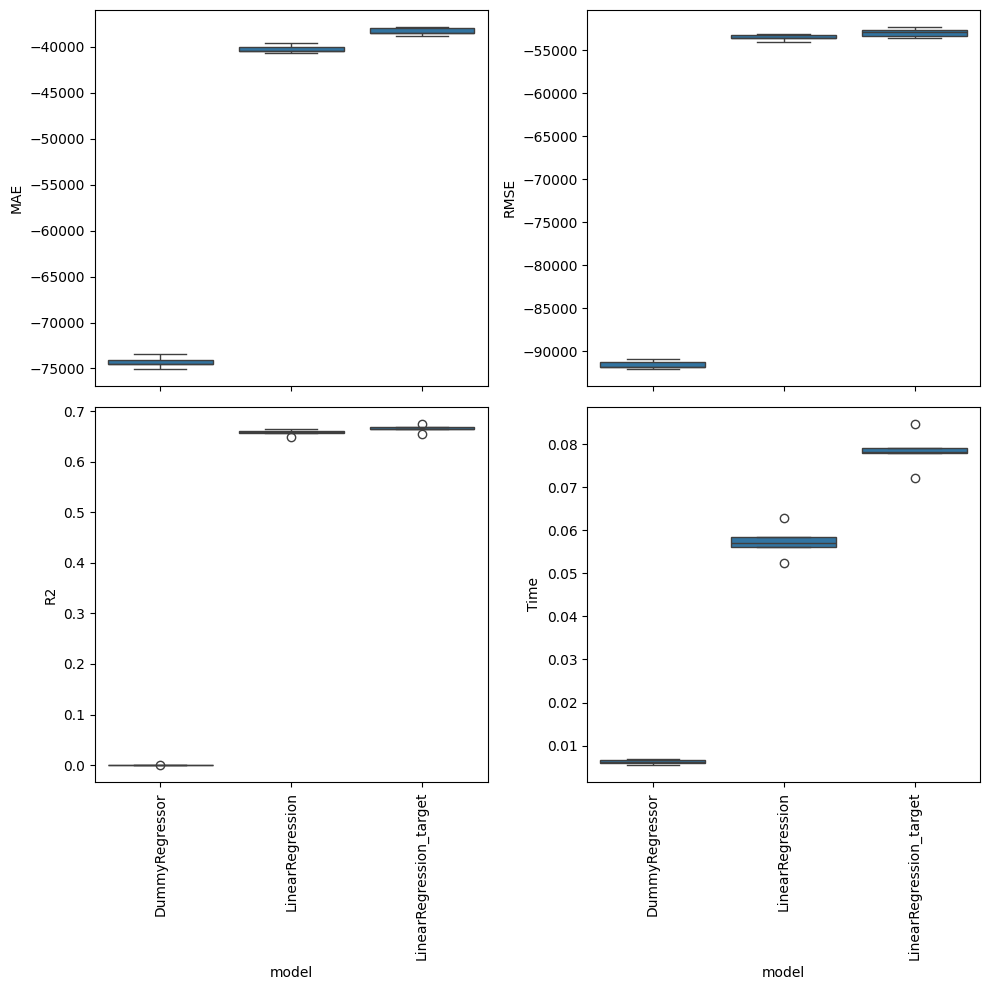

In [50]:
# Comparando as métricas de cada modelo
compareMetrics(df_results, ["MAE", "RMSE", "R2", "Time"])

In [51]:
# Separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Definindo a grade de parametros

param_grid = {
    "regressor__preprocessing__robust_poly__poly__degree": [1, 2, 3],
}

In [53]:
# Definição do grid search

grid_search = gridSearch(
    regressor=LinearRegression(),
    preprocessing=preprocessing,
    target_transform=QuantileTransformer(
        n_quantiles=1_000, 
        output_distribution="normal"
        ),
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessing',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat',
                                                                                                               'housing_median_age_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_poly',
                                                                                                              Pipeline(steps=[...
       'rooms_per_households', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('regressor',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessing__robust_poly__poly__degree': [1,
                                                                                 2,
                                                                                 3]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'],
             verbose=1)

In [54]:
# Ajuste dos pesos
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessing',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat',
                                                                                                               'housing_median_age_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_poly',
                                                                                                              Pipeline(steps=[...
       'rooms_per_households', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('regressor',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessing__robust_poly__poly__degree': [1,
                                                                                 2,
                                                                                 3]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'r2'],
             verbose=1)

In [55]:
# Melhores parametros
grid_search.best_params_

{'regressor__preprocessing__robust_poly__poly__degree': 3}

In [56]:
# Estimador com melhores parametros
grid_search.best_estimator_

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                       OrdinalEncoder(),
                                                                                       ['median_income_cat',
                                                                                        'housing_median_age_cat']),
                                                                                      ('one_hot',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['ocean_proximity']),
                                                                                      ('robust_poly',
                                                                                       Pipeline(steps=[('poly',
                                                                                                        PolynomialFeatures(degree=3,
                                                                                                                           include_bias=False)),
                                                                                                       ('robust',
                                                                                                        RobustScaler())]),
                                                                                       Index(['bedrooms_per_rooms', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_households',
       'rooms_per_households', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                     ('regressor',
                                                      LinearRegression())]),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [57]:
# Coeficientes das features

df_coeffs = getCoeffsDataframe(
    grid_search.best_estimator_.regressor_["regressor"].coef_,
    grid_search.best_estimator_.regressor_["preprocessing"].get_feature_names_out(),
)
df_coeffs

,coeficientes
robust_poly__longitude^2 total_bedrooms,-1800.063025
robust_poly__longitude rooms_per_households,-1720.427418
robust_poly__longitude total_bedrooms,-1557.316756
robust_poly__bedrooms_per_rooms longitude total_rooms,-1557.316756
robust_poly__longitude^2 rooms_per_households,-1216.567693
...,...
robust_poly__longitude total_rooms,1454.806205
robust_poly__households longitude rooms_per_households,1454.806205
robust_poly__latitude^2 longitude,1567.945246
robust_poly__latitude longitude^2,1713.990334


In [65]:
# Verificando se algum coeficiente foi zerado
df_coeffs[df_coeffs["coeficientes"] == 0]

,coeficientes


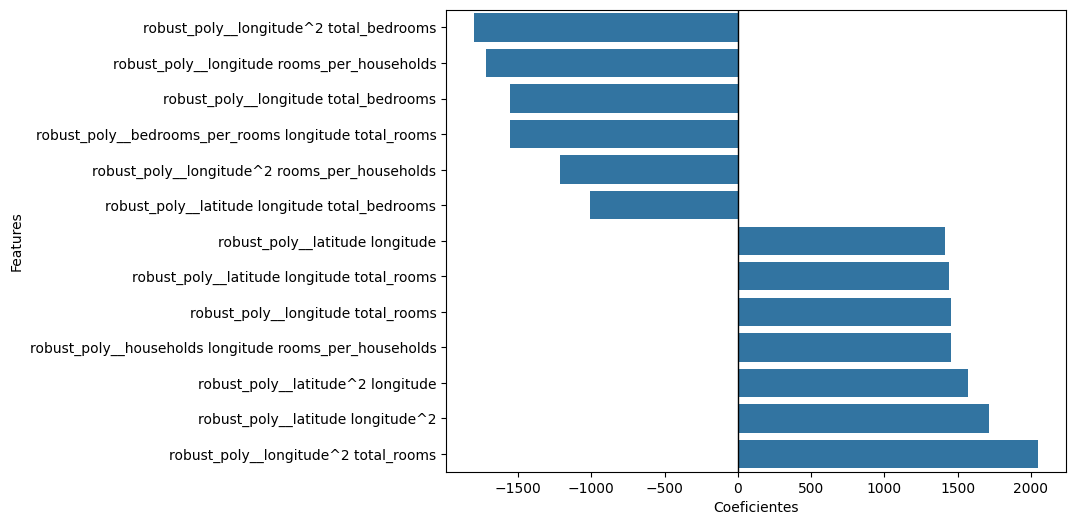

In [58]:
# Gerando gráfico desses coeficientes
plotCoeffs(
    df_coeffs[~df_coeffs["coeficientes"].between(
        -1_000, 1_000
        )]
    )

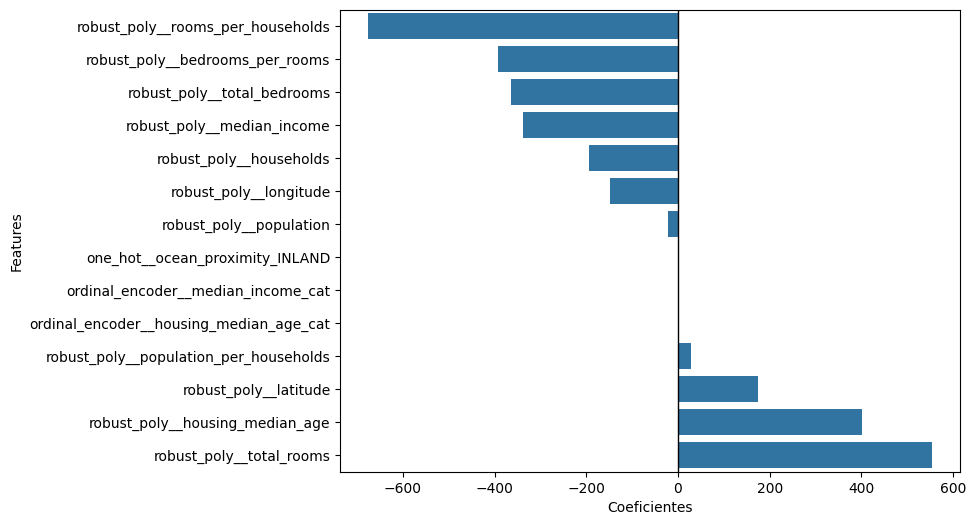

In [59]:
# Gerando gráfico desses coeficientes dos parametros lineares
non_linear_pattern = re.compile(r"\^[2-9]")

linear_parameters = df_coeffs.index[
    ~(df_coeffs.index.str.contains(" ")) & 
    ~(df_coeffs.index.str.contains(non_linear_pattern))
    ]

plotCoeffs(
    df_coeffs.loc[linear_parameters]
    )

In [60]:
# Definição dos regressores, com ou sem preprocessamentos nas coluna e/ou transformação no target

regressors = {
    "DummyRegressor": {
        "preprocessing": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transform": None,
    },
    "LinearRegression": {
        "preprocessing": preprocessing,
        "regressor": LinearRegression(),
        "target_transform": None,
    },
    "LinearRegression_target": {
        "preprocessing": preprocessing,
        "regressor": LinearRegression(),
        "target_transform": QuantileTransformer(
            n_quantiles=1_000,
            output_distribution="normal"
        ),
    },
    "LinearRegression_grid_search": {
        "preprocessing": grid_search.best_estimator_.regressor_["preprocessing"],
        "regressor": grid_search.best_estimator_.regressor_["regressor"],
        "target_transform": grid_search.best_estimator_.transformer_,
    },
}

# Obtendo os resultados de cada regressor

results = {
    name: trainAndValidate(X, y, **regressor) for name, regressor in regressors.items()
}

df_results = organizeResults(results)
df_results

,model,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time
0,DummyRegressor,-74496.622,-91828.212064,-0.000031,0.004316
1,DummyRegressor,-74033.8009,-90953.345064,-0.000072,0.008035
2,DummyRegressor,-73436.810725,-91261.635258,-0.000214,0.012057
3,DummyRegressor,-75005.696104,-92007.342962,-0.000095,0.009129
4,DummyRegressor,-74476.318859,-91827.966753,-0.000058,0.007573
5,LinearRegression,-40461.156491,-53585.381591,0.659471,0.086117
6,LinearRegression,-40497.930626,-53229.728607,0.657467,0.107261
7,LinearRegression,-40657.91515,-54061.914203,0.649006,0.064497
8,LinearRegression,-39544.196294,-53556.524508,0.661139,0.083699
9,LinearRegression,-39999.623133,-53140.949033,0.665085,0.092203


In [61]:
# Agrupando a mediana das métricas de cada modelo
df_results.groupby("model").median()

,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,test_r2,time
model,,,,
DummyRegressor,-74476.318859,-91827.966753,-0.000072,0.008035
LinearRegression,-40461.156491,-53556.524508,0.659471,0.086117
LinearRegression_grid_search,-34935.364347,-49091.528808,0.710579,2.124246
LinearRegression_target,-38403.668358,-52517.250883,0.670513,0.070615


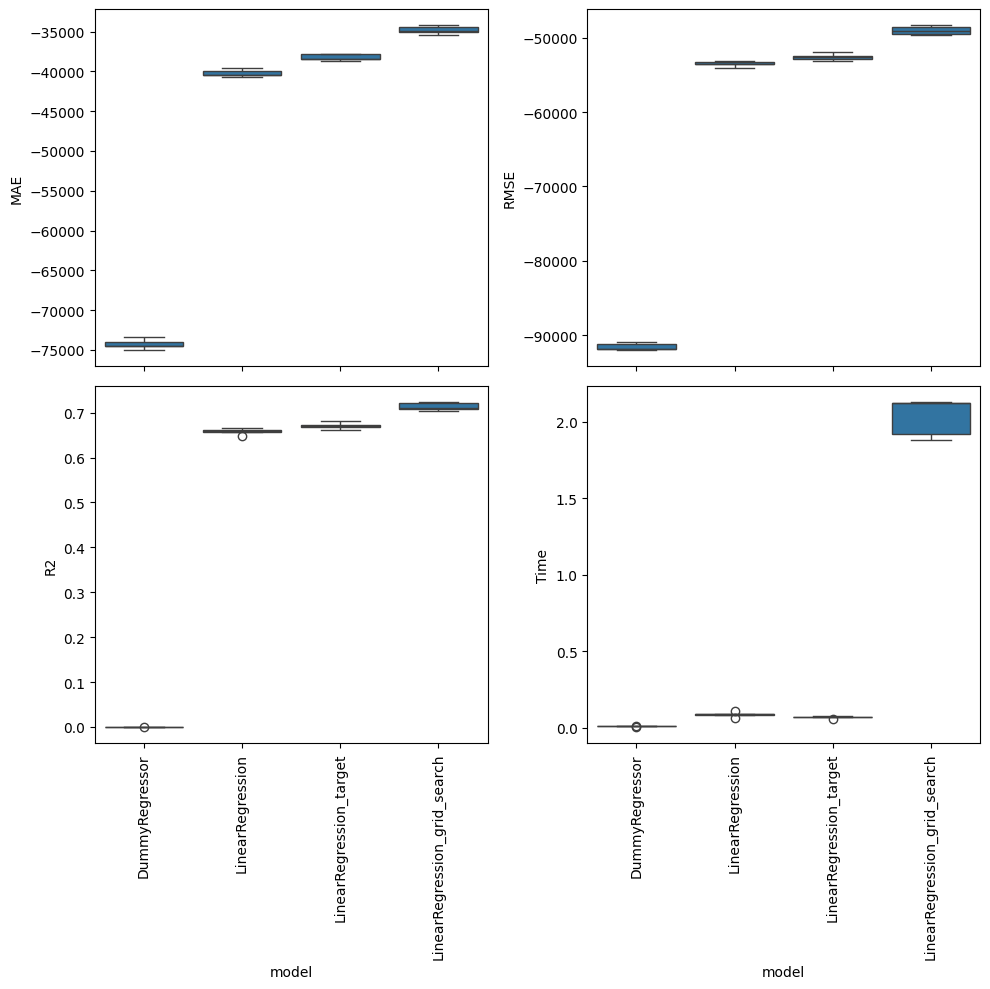

In [62]:
# Comparação das métricas de cada modelo
compareMetrics(df_results, ["MAE", "RMSE", "R2", "Time"])

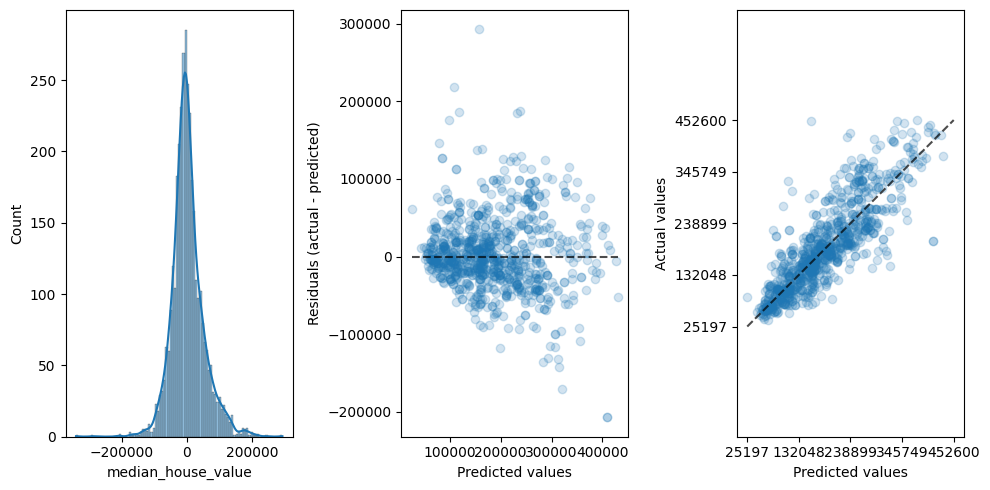

In [63]:
# Gráficos de residuos

y_pred = grid_search.best_estimator_.predict(X_test)

plotResiduals(y_test, y_pred)

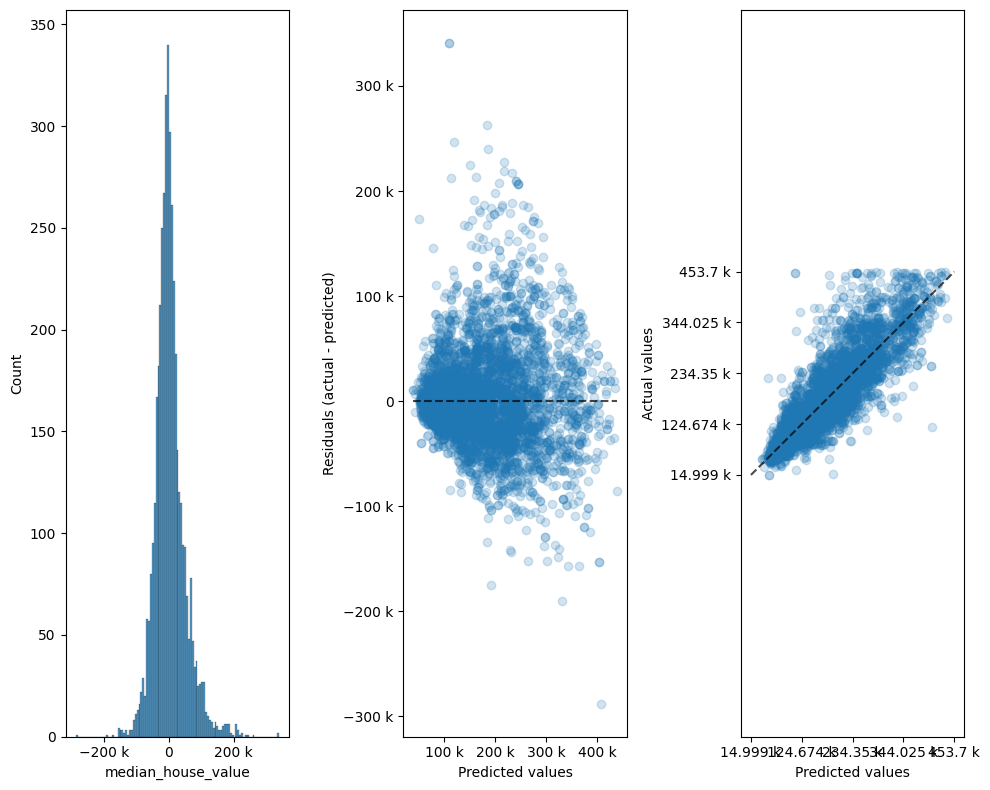

In [64]:
plotResidualsFromEstimator(grid_search.best_estimator_, X, y, eng_formatter=True)